# ML Project

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import random
import metoder
import pandas as pd




Importing dataset:

In [24]:
#path:
#file_path = r"C:\Users\vikto\Documents\Skole\Datadrevne_systemer\ML_Project\glass_data-4_lev.csv"
file_path_training = "../Datasett/train_set.csv"
file_path_test = "../Datasett/test_set.csv"
file_path_total_set =   "../Datasett/mushrooms.csv"
#importing file and print how the structure of data were inported. 
df_training = pd.read_csv(file_path_training)
df_test = pd.read_csv(file_path_test)
df_total = pd.read_csv(file_path_total_set)



#drop ID number
#df = df.drop(columns=['Id'])

print(df_total['class'].dtype)
df_total.info()

object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   class                  8124 non-null   object
 1   capShape               8124 non-null   object
 2   capSurface             8124 non-null   object
 3   capColor               8124 non-null   object
 4   bruises                8124 non-null   object
 5   odor                   8124 non-null   object
 6   gillAttachment         8124 non-null   object
 7   gillSpacing            8124 non-null   object
 8   gillSize               8124 non-null   object
 9   gillColor              8124 non-null   object
 10  stalkShape             8124 non-null   object
 11  stalkRoot              8124 non-null   object
 12  stalkSurfaceAboveRing  8124 non-null   object
 13  stalkSurfaceBelowRing  8124 non-null   object
 14  stalkColorAboveRing    8124 non-null   object
 15  stalkColorBelo

### Small exploration of data:

In [25]:
# Check the number of unique rows in the DataFrame
num_unique_rows = df_total.drop_duplicates().shape[0]

# Print the result
print("Number of unique rows:", num_unique_rows)

Number of unique rows: 8124


The data set clearly shows that T1, T2 is most frequently. 

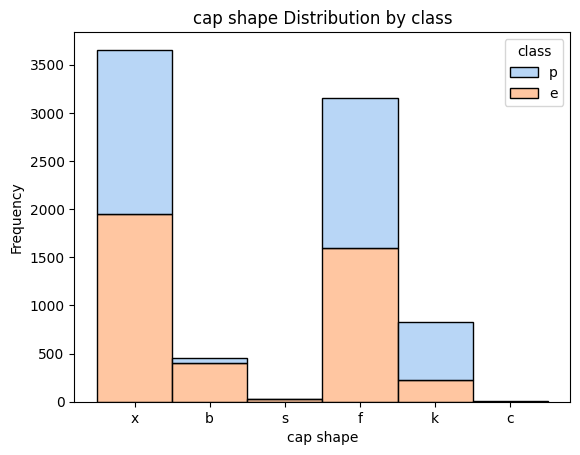

In [26]:
# Create a histogram of age with hue for income
sns.histplot(data=df_total, x='capShape', hue='class', multiple='stack', palette='pastel')

# Add labels and title
plt.xlabel('cap shape')
plt.ylabel('Frequency')
plt.title('cap shape Distribution by class')

# Show the plot
plt.show()

In [27]:
#for col in df.columns[:-1]:  # Exclude the 'Type' column
 #   sns.boxplot(x='Type', y=col, data=df)
  #  plt.show()

One-hot encoding to ensure the best result

In [40]:
# Perform one-hot encoding for all categorical columns except the "class" column
# Perform one-hot encoding for all categorical columns except the "class" column
df_train_encoded = pd.get_dummies(df_training, columns=["capShape", "capSurface", "capColor", "bruises", "odor", "gillAttachment", "gillSpacing", "gillSize", "gillColor", "stalkShape", "stalkRoot", "stalkSurfaceAboveRing", "stalkSurfaceBelowRing", "stalkColorAboveRing", "stalkColorBelowRing", "veilType", "veilColor", "ringNumber", "ringType", "sporePrintColor", "population", "habitat"])
df_test_encoded = pd.get_dummies(df_test, columns=["capShape", "capSurface", "capColor", "bruises", "odor", "gillAttachment", "gillSpacing", "gillSize", "gillColor", "stalkShape", "stalkRoot", "stalkSurfaceAboveRing", "stalkSurfaceBelowRing", "stalkColorAboveRing", "stalkColorBelowRing", "veilType", "veilColor", "ringNumber", "ringType", "sporePrintColor", "population", "habitat"])

# Replace "p" with 1 and "e" with 0 in the "class" column in the df_training and df_test DataFrames
df_train_encoded['class'] = df_train_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)
df_test_encoded['class'] = df_test_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)

# Splitting into features (X) and target variable (y)
X_train, y_train = df_train_encoded.drop(['class'], axis=1), df_train_encoded['class']
X_test, y_test = df_test_encoded.drop(['class'], axis=1), df_test_encoded['class']

print(X_train.head())


   capShape_b  capShape_c  capShape_f  capShape_k  capShape_s  capShape_x  \
0       False       False       False        True       False       False   
1       False       False       False       False       False        True   
2       False       False        True       False       False       False   
3       False       False        True       False       False       False   
4        True       False       False       False       False       False   

   capSurface_f  capSurface_g  capSurface_s  capSurface_y  ...  population_s  \
0         False         False          True         False  ...         False   
1         False         False          True         False  ...         False   
2         False         False         False          True  ...         False   
3          True         False         False         False  ...         False   
4         False         False         False          True  ...         False   

   population_v  population_y  habitat_d  habitat_g  hab

### Make a neural network:

Split data to training and validation and Scale the data: 

Epoch 1/10
204/204 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.9563 - val_loss: 0.0155 - val_accuracy: 0.9982
Epoch 2/10
204/204 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 3/10
204/204 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 9.8725e-04 - val_accuracy: 1.0000
Epoch 4/10
204/204 [==============================] - 0s 2ms/step - loss: 5.4205e-04 - accuracy: 1.0000 - val_loss: 4.4018e-04 - val_accuracy: 1.0000
Epoch 5/10
204/204 [==============================] - 0s 2ms/step - loss: 2.8249e-04 - accuracy: 1.0000 - val_loss: 2.7557e-04 - val_accuracy: 1.0000
Epoch 6/10
204/204 [==============================] - 0s 2ms/step - loss: 1.7321e-04 - accuracy: 1.0000 - val_loss: 1.7684e-04 - val_accuracy: 1.0000
Epoch 7/10
204/204 [==============================] - 0s 2ms/step - loss: 1.1189e-04 - accuracy: 1.0000 - val_loss: 1.28

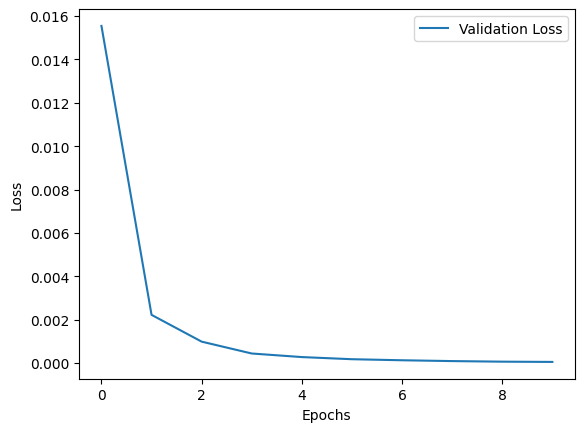

In [43]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and get the training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the validation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Create pytorch model:

Evaluate model:

In [29]:
# Results storage as a dictionary
results = {}

In [30]:
# Call each function and store the results
accuracy, confusion_matrix = metoder.randomforest(X_train, X_test, y_train, y_test)
results['randomforest'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [31]:
accuracy, confusion_matrix = metoder.gradientboost(X_train, X_test, y_train, y_test)
results['gradientboost'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [32]:
#accuracy, confusion_matrix = metoder.linearregression(X_train, X_test, y_train, y_test)
#results['linearregression'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}


LinAlgError: SVD did not converge in Linear Least Squares

In [33]:
accuracy, confusion_matrix = metoder.decisionregressor(X_train, X_test, y_train, y_test)
results['decisionregressor'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [34]:
accuracy, confusion_matrix = metoder.mlpregression(X_train, X_test, y_train, y_test)
results['mlpregression'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [35]:
accuracy, confusion_matrix = metoder.supportvectoregressor(X_train, X_test, y_train, y_test)
results['supportvectoregressor'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [36]:

accuracy, confusion_matrix = metoder.kneighborsregressor(X_train, X_test, y_train, y_test)
results['kneighborsregressor'] = {'accuracy': accuracy, 'confusion_matrix': confusion_matrix}

In [37]:
#make tree lists of dictionary: 
algorithm_names = []
accuracies = []
confusion_matrices = []

for algorithm, results_info in results.items():
    algorithm_names.append(algorithm)
    accuracies.append(results_info['accuracy'])
    confusion_matrices.append(results_info['confusion_matrix'])

In [38]:
compare_models = pd.DataFrame({ "Algorithms": algorithm_names, "accuracy": accuracies})
compare_models.sort_values(by = "accuracy", ascending = False)

,Algorithms,accuracy
0,randomforest,1.0
1,gradientboost,1.0
2,decisionregressor,1.0
3,mlpregression,1.0
4,supportvectoregressor,1.0
5,kneighborsregressor,1.0


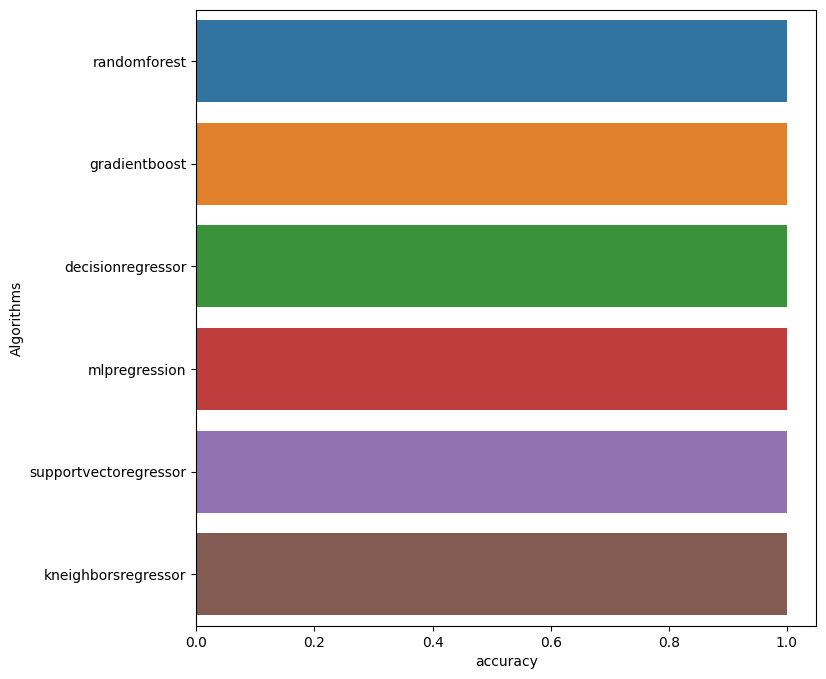

In [39]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "accuracy", y = "Algorithms", data = compare_models)
plt.show()